# Item Forecasting

## Import Libraries

In [316]:
import numpy as np
import pandas as pd
from sqlalchemy import text
import sys
import os
from IPython.display import display, Math
import matplotlib.pyplot as plt
from prophet import Prophet

sys.path.append(os.path.abspath('..'))
from utils.db import get_db
from utils import find_missing_dates
from utils.fill_dates import fill_missing_dates

In [288]:
engine = get_db()

## Get Data

In [330]:
history_query = """select sale_date, product_code, product_description, sum(qty) as qty, sum(total_sales) as sales
from sales
where sale_date between '4/1/2025' and '5/31/2025'
and store_number='440'
and sale_type='Sale'
and item_ring_type = 'ITEM'
and product_description ilike 'am%milk%'
group by sale_date, product_code, product_description
order by sale_date, sum(qty) desc
"""

In [331]:
future_query = """select sale_date, product_code, product_description, sum(qty) as qty, sum(total_sales) as sales
from sales
where sale_date between '6/1/2025' and '6/7/2025'
and store_number='440'
and sale_type='Sale'
and item_ring_type = 'ITEM'
and product_description ilike 'am%milk%'
group by sale_date, product_code, product_description
order by sale_date, sum(qty) desc
"""

In [332]:
original = pd.read_sql((text(history_query)),engine)

2025-06-15 15:17:29,209 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-06-15 15:17:29,210 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-06-15 15:17:29,210 INFO sqlalchemy.engine.Engine [cached since 816.4s ago] {'table_name': <sqlalchemy.sql.elements.TextClause object at 0x0000016F1FF4E570>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2025-06-15 15:17:29,211 INFO sqlalchemy.engine.Engine select sale_date, product_code, product_description, sum(qty) as qty, sum(total_sales) as sales
from sales
where sale_da

In [333]:
actual = pd.read_sql(text(future_query), engine)

2025-06-15 15:17:39,982 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-06-15 15:17:39,982 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-06-15 15:17:39,984 INFO sqlalchemy.engine.Engine [cached since 827.1s ago] {'table_name': <sqlalchemy.sql.elements.TextClause object at 0x0000016F1F4E5FD0>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2025-06-15 15:17:39,984 INFO sqlalchemy.engine.Engine select sale_date, product_code, product_description, sum(qty) as qty, sum(total_sales) as sales
from sales
where sale_da

In [334]:
original.head()

,sale_date,product_code,product_description,qty,sales
0,2025-04-01,84023020002.0,AM CH MILK 2% GALN 128 OZ,46.0,159.75
1,2025-04-01,84023020001.0,AM CH MILK WHOLE GAL 128 OZ,35.0,125.08
2,2025-04-01,84023020006.0,AM CH MILK 2% HGAL 64 OZ,20.0,52.16
3,2025-04-01,84023020005.0,AM CH MILK WHOLE HGAL 64 OZ,9.0,23.99
4,2025-04-01,84023020004.0,AM CH MILK SKIM GAL 128 OZ,8.0,27.30


In [335]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   sale_date            401 non-null    datetime64[ns]
 1   product_code         401 non-null    object        
 2   product_description  401 non-null    object        
 3   qty                  401 non-null    float64       
 4   sales                401 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 15.8+ KB


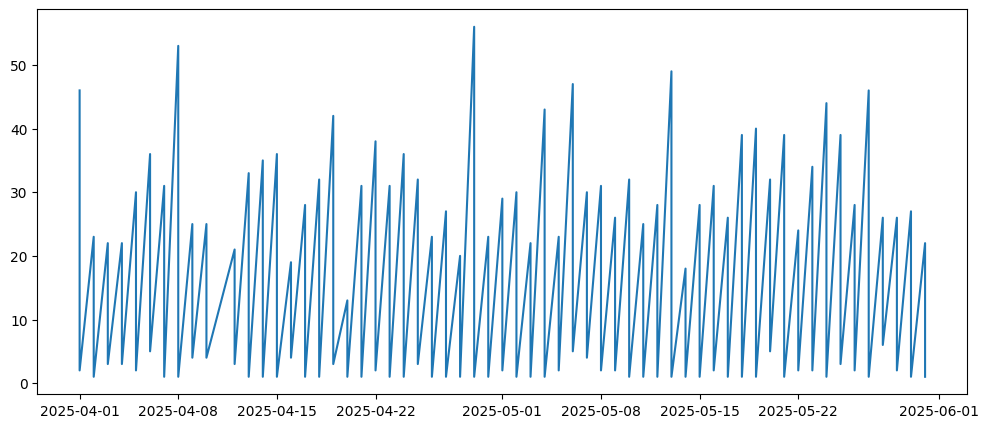

In [336]:
plt.figure(figsize=(12,5))
plt.plot(original['sale_date'], original['qty'])
plt.show()

In [341]:
missing_dates = find_missing_dates(original, 'sale_date', original['sale_date'].min(), original['sale_date'].max())
missing_dates

[]

In [340]:
original = fill_missing_dates(original,date_col='sale_date', sales_col='qty',  start_date=original['sale_date'].min(), end_date=original['sale_date'].max(), fill_value=0)

In [342]:
print(f' there are {original['product_description'].nunique()} unique products')
print(actual['product_description'].unique())

 there are 8 unique products
['AM CH MILK 2% HGAL 64 OZ' 'AM CH MILK 2% GALN 128 OZ'
 'AM CH MILK WHOLE GAL 128 OZ' 'AM CH MILK WHOLE HGAL 64 OZ'
 'AM CH MILK 1% GAL 128 OZ' 'AM CH MILK SKIM GAL 128 OZ'
 'AM CH MILK SKIM HGAL 64 OZ']


In [343]:
full_range = pd.date_range(start=original['sale_date'].min(), end=original['sale_date'].max())

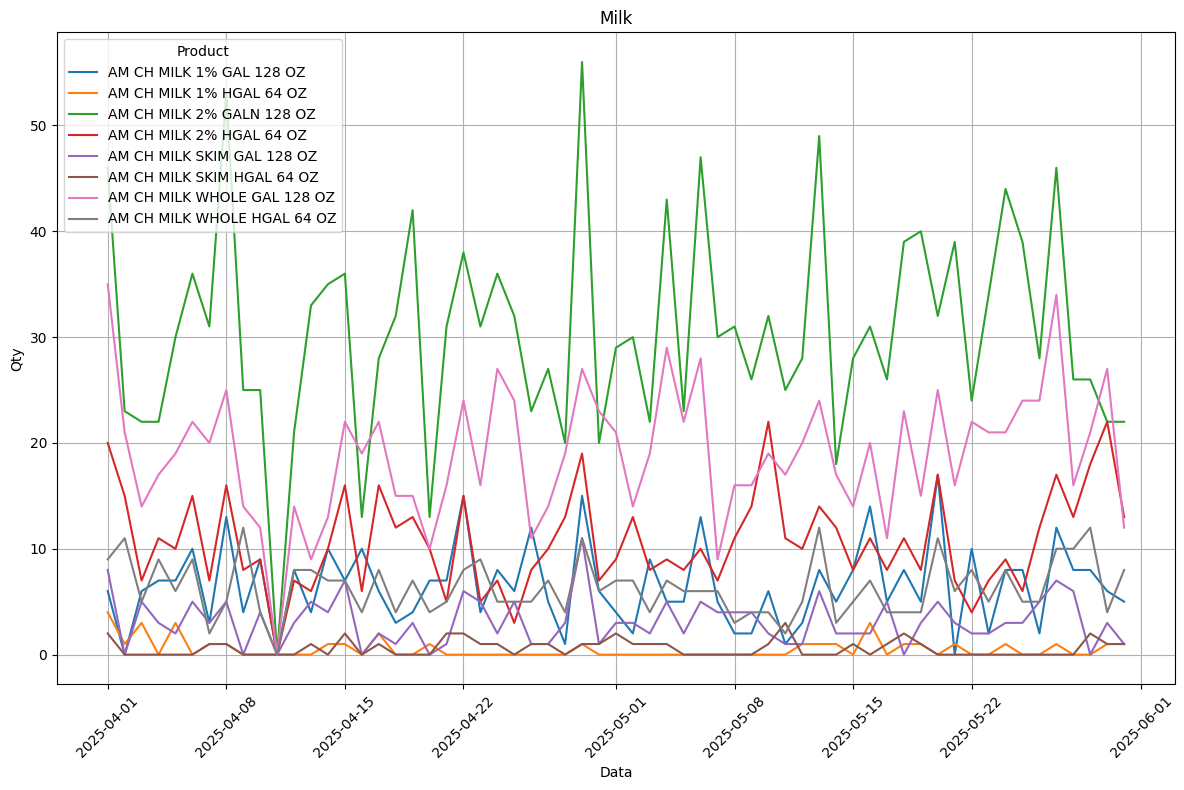

In [344]:

product_datasets = {}

for name, group in original.groupby('product_description'):
    group = group.set_index('sale_date').sort_index()
    reindexed = group.reindex(full_range)
    reindexed['qty'] = reindexed['qty'].fillna(0)
    reindexed['sales'] = reindexed['sales'].fillna(0)
    reindexed['product_description'] = name
    reindexed['date'] = reindexed.index
    product_datasets[name] = reindexed.reset_index(drop=True)
plt.figure(figsize=(12,8))

for name, product in product_datasets.items():
    plt.plot(product['date'], product['qty'], label=name)


plt.title('Milk')
plt.xlabel('Data')
plt.ylabel('Qty')
plt.legend(title='Product')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()  
plt.show()  

In [345]:
original['sale_date'] = pd.to_datetime(original['sale_date'])
actual['sale_date'] = pd.to_datetime(actual['sale_date'])

In [346]:
product_dfs = {}
for  name, group in original.groupby('product_description'):
    df_p = group.set_index('sale_date').reindex(full_range)
    df_p['qty'] = df_p['qty'].fillna(0)
    df_p['sales'] = df_p['sales'].fillna(0)
    df_p['product_description'] = name
    df_p['product_code'] = group['product_code'].iloc[0]
    df_p['date'] = full_range
    product_dfs[name] = df_p.reset_index(drop=True)

    

In [347]:
# forecast each product and collect results
all_forecasts = []
for name, df_p in product_dfs.items():
    prophet_df = df_p[['date', 'qty']].rename(columns={'date': 'ds', 'qty': 'y'})
    m = Prophet(daily_seasonality=True)
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat']].tail(7)
    forecast['product_description'] = name
    all_forecasts.append(forecast)



15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:30 - cmdstanpy - INFO - Chain [1] start processing
15:22:30 - cmdstanpy - INFO - Chain [1] done processing
15:22:30 - cmdstanpy - INFO - Chain [1] start processing
15:22:30 - cmdstanpy - INFO - Chain [1] done processing


In [348]:
forecast_df = pd.concat(all_forecasts)
forecast_df = forecast_df.rename(columns={'ds': 'sale_date', 'yhat': 'forecast_qty'})

In [349]:
forecast_df

,sale_date,forecast_qty,product_description
61,2025-06-01,6.451979,AM CH MILK 1% GAL 128 OZ
62,2025-06-02,4.945048,AM CH MILK 1% GAL 128 OZ
63,2025-06-03,12.306614,AM CH MILK 1% GAL 128 OZ
64,2025-06-04,5.162339,AM CH MILK 1% GAL 128 OZ
65,2025-06-05,7.283389,AM CH MILK 1% GAL 128 OZ
66,2025-06-06,5.162496,AM CH MILK 1% GAL 128 OZ
67,2025-06-07,7.618439,AM CH MILK 1% GAL 128 OZ
61,2025-06-01,-0.053017,AM CH MILK 1% HGAL 64 OZ
62,2025-06-02,0.197101,AM CH MILK 1% HGAL 64 OZ
63,2025-06-03,0.663419,AM CH MILK 1% HGAL 64 OZ


In [350]:
comparison = pd.merge(
    forecast_df,
    actual[['sale_date', 'product_description', 'qty']],
    on=['sale_date', 'product_description'],
    how='inner'
)

In [354]:
comparison

,sale_date,forecast_qty,product_description,qty,error,abs_error,ape
0,2025-06-01,6.451979,AM CH MILK 1% GAL 128 OZ,6.0,0.451979,0.451979,0.075330
1,2025-06-02,4.945048,AM CH MILK 1% GAL 128 OZ,5.0,-0.054952,0.054952,0.010990
2,2025-06-03,12.306614,AM CH MILK 1% GAL 128 OZ,7.0,5.306614,5.306614,0.758088
3,2025-06-04,5.162339,AM CH MILK 1% GAL 128 OZ,15.0,-9.837661,9.837661,0.655844
4,2025-06-05,7.283389,AM CH MILK 1% GAL 128 OZ,9.0,-1.716611,1.716611,0.190735
5,2025-06-06,5.162496,AM CH MILK 1% GAL 128 OZ,5.0,0.162496,0.162496,0.032499
6,2025-06-07,7.618439,AM CH MILK 1% GAL 128 OZ,5.0,2.618439,2.618439,0.523688
7,2025-06-01,34.257869,AM CH MILK 2% GALN 128 OZ,21.0,13.257869,13.257869,0.631327
8,2025-06-02,31.882992,AM CH MILK 2% GALN 128 OZ,31.0,0.882992,0.882992,0.028484
9,2025-06-03,47.428245,AM CH MILK 2% GALN 128 OZ,34.0,13.428245,13.428245,0.394948


In [352]:
comparison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   sale_date            45 non-null     datetime64[ns]
 1   forecast_qty         45 non-null     float64       
 2   product_description  45 non-null     object        
 3   qty                  45 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.5+ KB


In [353]:
comparison['error'] = comparison['forecast_qty'] - comparison['qty']
comparison['abs_error'] = comparison['error'].abs()
comparison['ape'] = (comparison['abs_error'] / comparison['qty'].replace(0, None))


In [355]:
mask1 = comparison['error'] < 0
mask2 = comparison['error'] > 0
print(f'there are {len(comparison)} total predictions. {len(comparison[mask1])} are negative and {len(comparison[mask2])} are positive')

there are 45 total predictions. 21 are negative and 24 are positive


In [356]:
# Summary stats
summary = comparison.groupby('product_description').agg({
    'qty': 'sum',
    'forecast_qty': 'sum',
    'abs_error': 'mean',
    'ape': 'mean',
}).rename(columns={
    'qty': 'actual_qty',
    'forecast_qty': 'forecast_qty',
    'abs_error': 'MAE',
    'ape': 'ape',
})

print(summary)

                             actual_qty  forecast_qty       MAE       ape
product_description                                                      
AM CH MILK 1% GAL 128 OZ           52.0     48.930302  2.878393  0.321025
AM CH MILK 2% GALN 128 OZ         216.0    231.381732  8.843597  0.293823
AM CH MILK 2% HGAL 64 OZ          108.0     73.388548  7.636716  0.298675
AM CH MILK SKIM GAL 128 OZ         17.0     21.967463  0.897897  0.465251
AM CH MILK SKIM HGAL 64 OZ          5.0      1.991381  0.752155  0.533137
AM CH MILK WHOLE GAL 128 OZ       158.0    149.708233  4.601610  0.210728
AM CH MILK WHOLE HGAL 64 OZ        89.0     45.285802  8.621997  1.345319


In [173]:
#comparison

In [357]:
copy = comparison[['sale_date', 'product_description', 'qty', 'forecast_qty']]


In [358]:
mape = ((abs(comparison['qty'] - comparison['forecast_qty']) / comparison['qty']) * 100).loc[comparison['qty'] != 0].mean()
mape


np.float64(49.72804949474584)